# Task 1. UNSUPERVISED LEARNING 

# Importing libraries


In [21]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

## Loadign the data

In [22]:
data = pd.read_csv("/Users/admin/Desktop/ML project/Code/Clustering/Customer_Segmentation.csv.xls", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


# Data Cleaning

In [23]:
#Information on features 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

## Take care of missing values

In [24]:
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data)) # Removing missing values

The total number of data-points after removing the rows with missing values are: 2216


## Taking care of Dt_Customer

In [25]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))


The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


### Creating (Customer_for) when the customer started shopping

In [26]:
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

## Feature engineering

In [27]:
data["Age"] = 2024-data["Year_Birth"] #Current age

#All spendings
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#All kids in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#All people in the family
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Parent
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Education into 3 groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#New data
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Get rid of not necessary attributes
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

### New data

In [28]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,55.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,28.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,47.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,54.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,65.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,131.000000,2525.000000,3.000000,5.000000,1.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

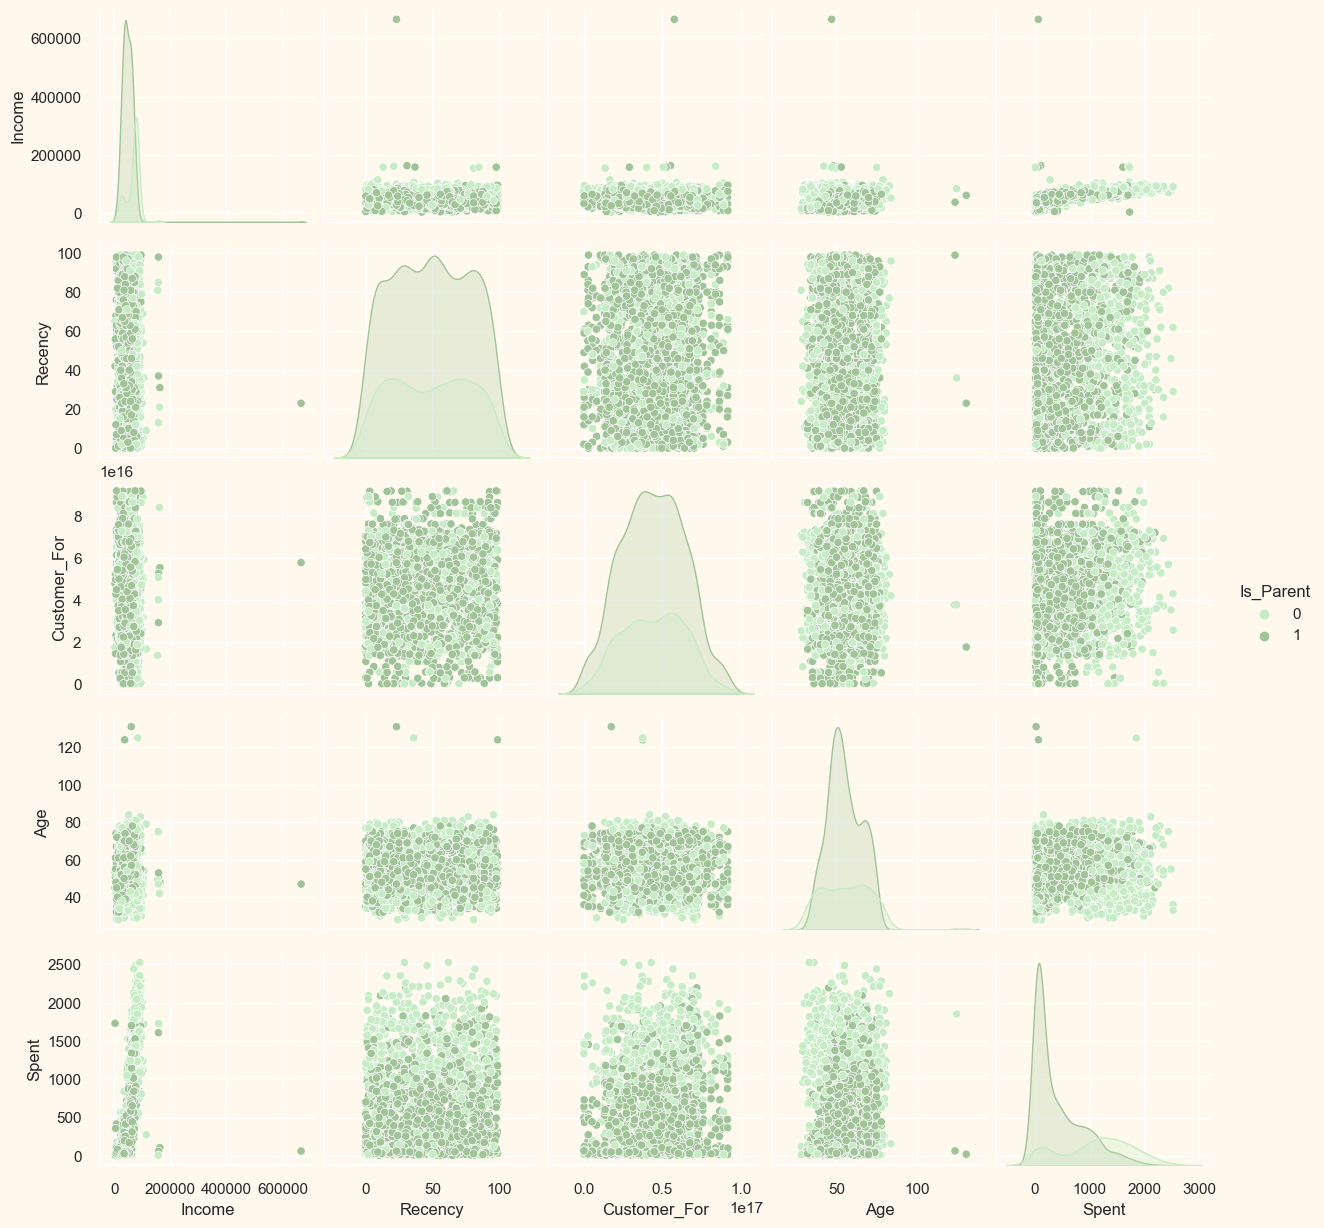

In [29]:
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#C6EBC5","#A1C398"]))
#Taking hue 
plt.show()

### Dropping outlienrs

In [30]:
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


# Data Preprocessing


In [31]:
#Doing the list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [32]:
#Labeling encoding object
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform) # All features now numeric

In [33]:
ds = data.copy() #creating the copy of the data

In [34]:
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

In [35]:
print(ds)

      Education   Income  Kidhome  Teenhome  Recency  Wines  Fruits  Meat  \
0             0  58138.0        0         0       58    635      88   546   
1             0  46344.0        1         1       38     11       1     6   
2             0  71613.0        0         0       26    426      49   127   
3             0  26646.0        1         0       26     11       4    20   
4             1  58293.0        1         0       94    173      43   118   
...         ...      ...      ...       ...      ...    ...     ...   ...   
2235          0  61223.0        0         1       46    709      43   182   
2236          1  64014.0        2         1       56    406       0    30   
2237          0  56981.0        0         0       91    908      48   217   
2238          1  69245.0        0         1        8    428      30   214   
2239          1  52869.0        1         1       40     84       3    61   

      Fish  Sweets  ...  NumCatalogPurchases  NumStorePurchases  \
0      1

## Scaling

In [36]:
#Scaling all features
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )

In [37]:
print("This dataframe will be used for the future modeling:")
scaled_ds.head()

This dataframe will be used for the future modeling:


,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,...,2.503607,-0.555814,0.692181,1.973583,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,...,-0.571340,-1.171160,-0.132545,-1.665144,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,...,-0.229679,1.290224,-0.544908,-0.172664,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,...,-0.913000,-0.555814,0.279818,-1.923210,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,...,0.111982,0.059532,-0.132545,-0.822130,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


# Demensionality Reduction

In [38]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,1.284887e-17,2.878377,-5.969394,-2.538494,-0.780421,2.383290,7.444305
col2,2212.0,-8.994212e-17,1.706839,-4.312196,-1.328316,-0.158123,1.242289,6.142721
col3,2212.0,1.445498e-17,1.221956,-3.530416,-0.829067,-0.022692,0.799895,6.611222


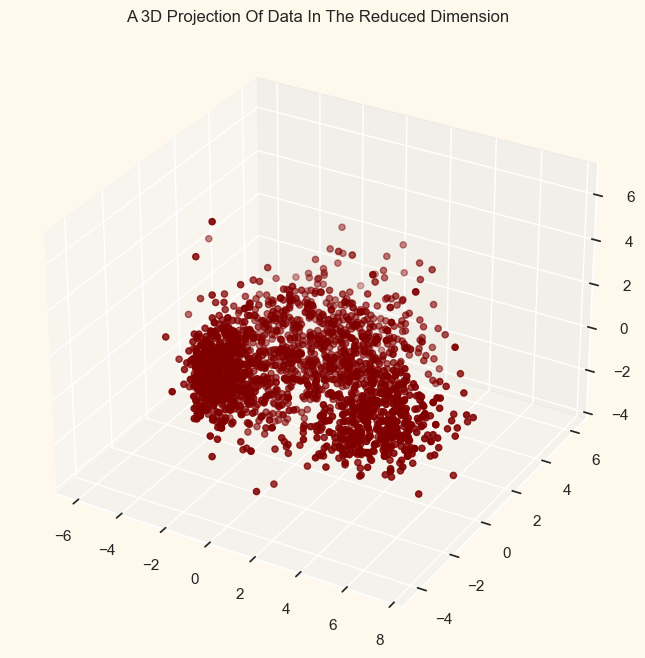

In [39]:
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# CLUSTERING

Elbow Method to determine the number of clusters to be formed:


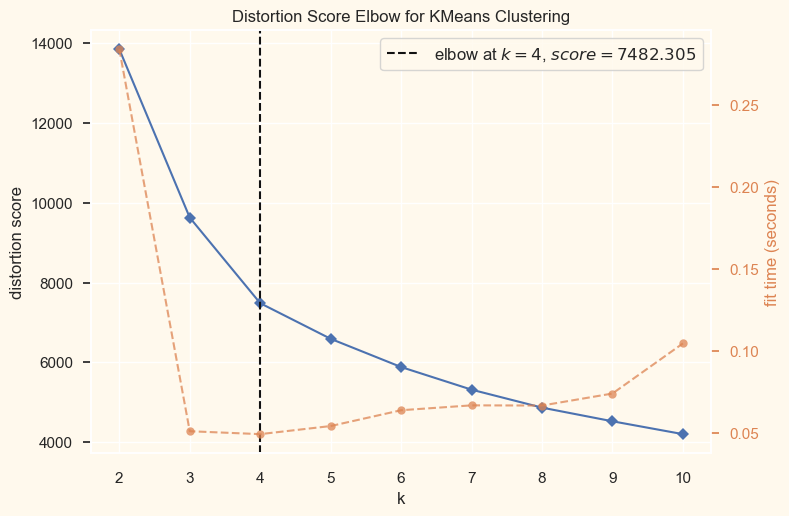

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

## Impelementing Agglomerative Clustering model

In [41]:
AC = AgglomerativeClustering(n_clusters=4)

# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC

#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

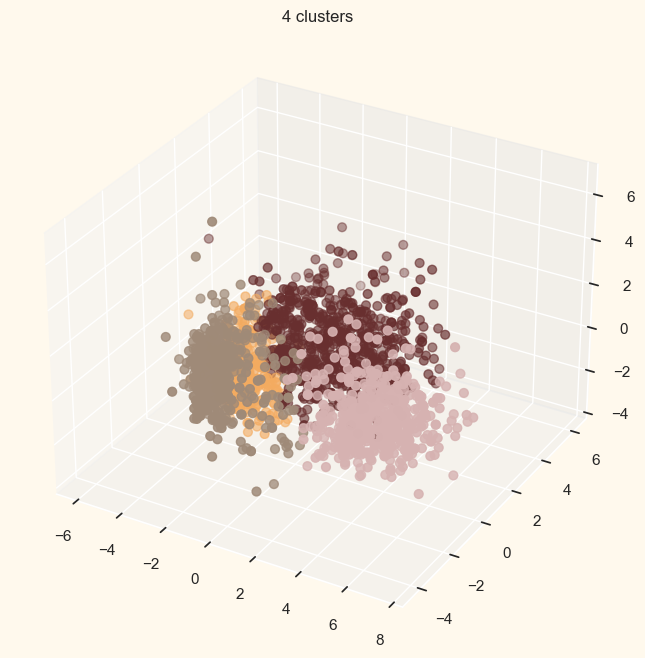

In [42]:
# See the clsuter
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("4 clusters")
plt.show()

# EVALUATION

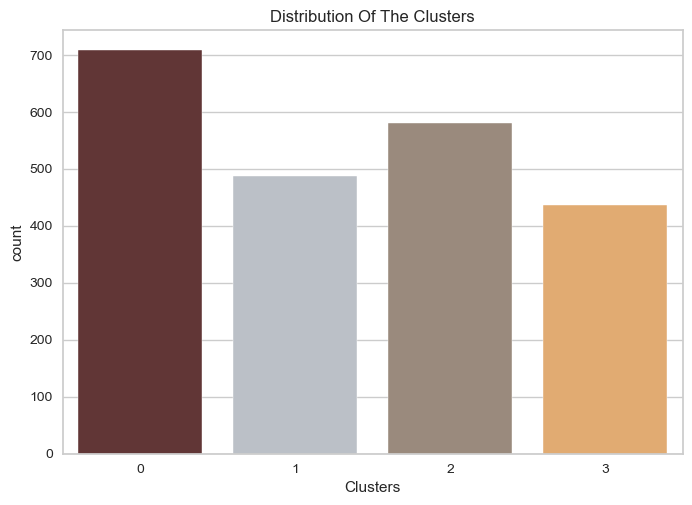

In [97]:
#Distrubution of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

Distrubuted fairly

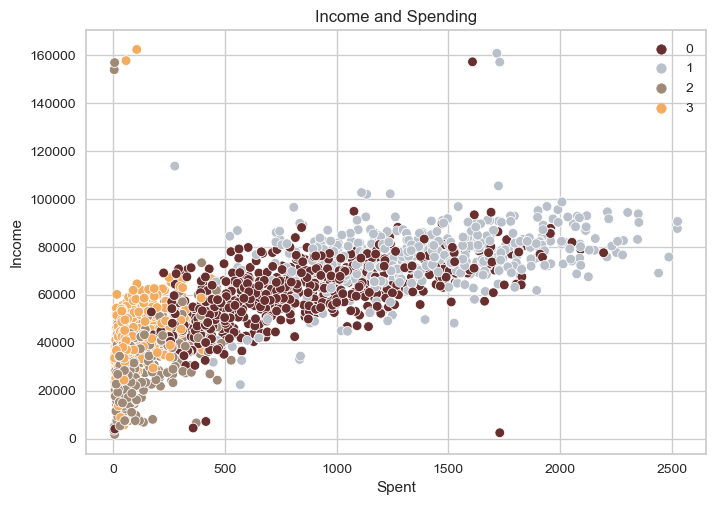

In [99]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Income and Spending")
plt.legend()
plt.show()

Now we can look at what each cluster spends

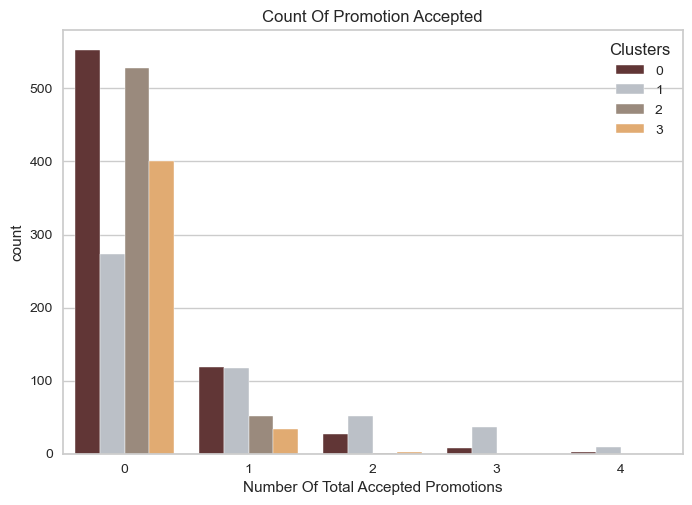

In [100]:
#Creating a feature to get a sum of accepted promotions 
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

There's a few respond to compaign so far. Very few people. Maybe the company should work on better campaigns and sales


# Profiling

<Figure size 800x550 with 0 Axes>

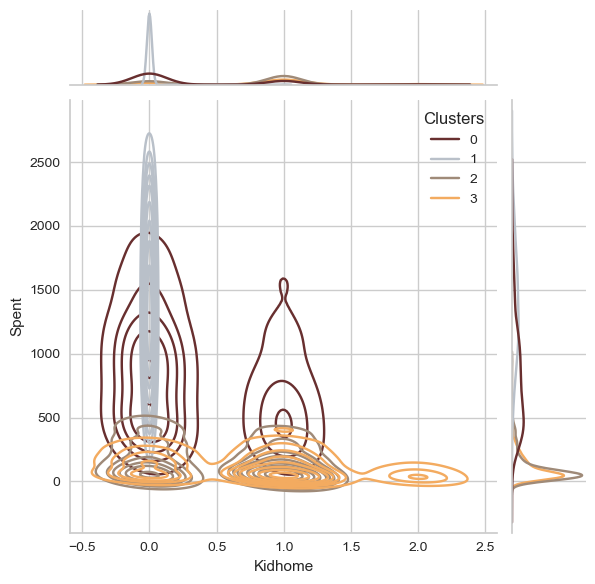

<Figure size 800x550 with 0 Axes>

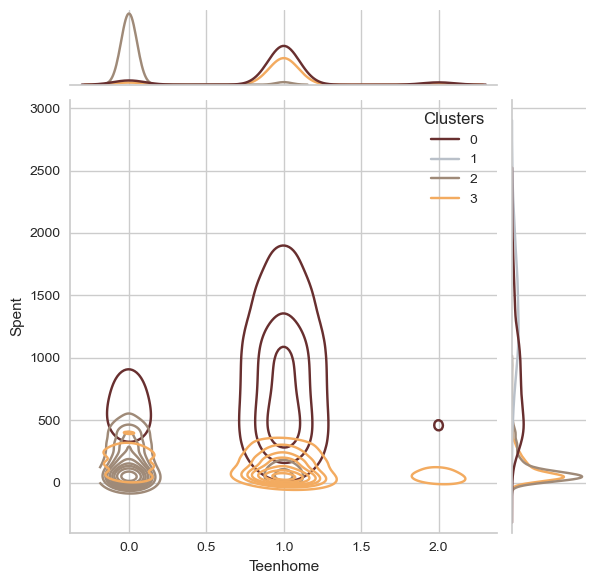

<Figure size 800x550 with 0 Axes>

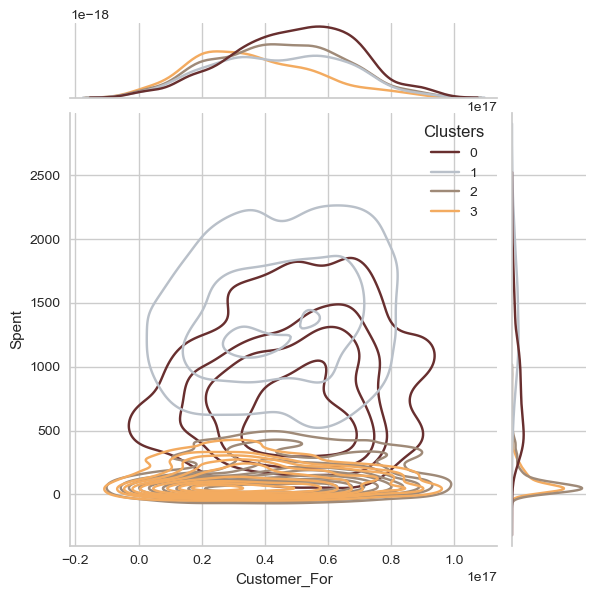

<Figure size 800x550 with 0 Axes>

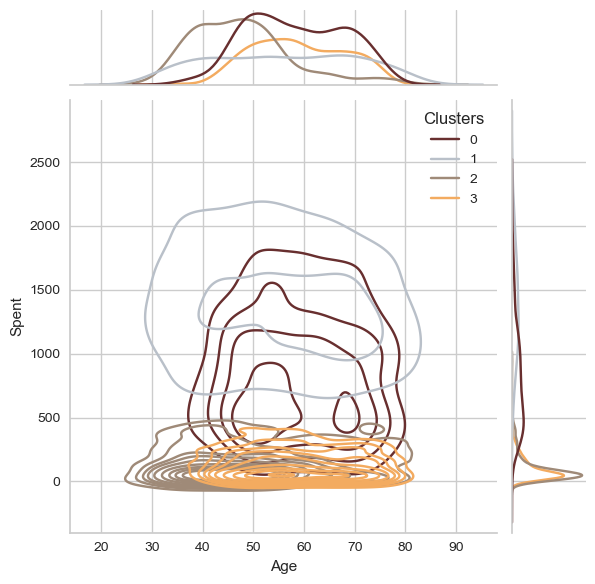

<Figure size 800x550 with 0 Axes>

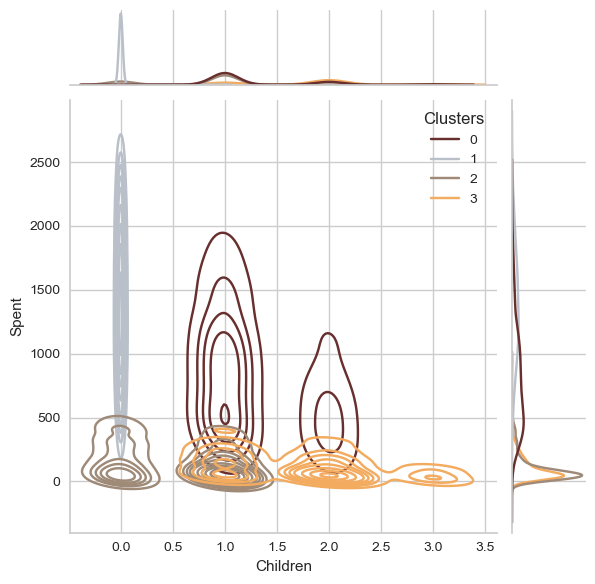

<Figure size 800x550 with 0 Axes>

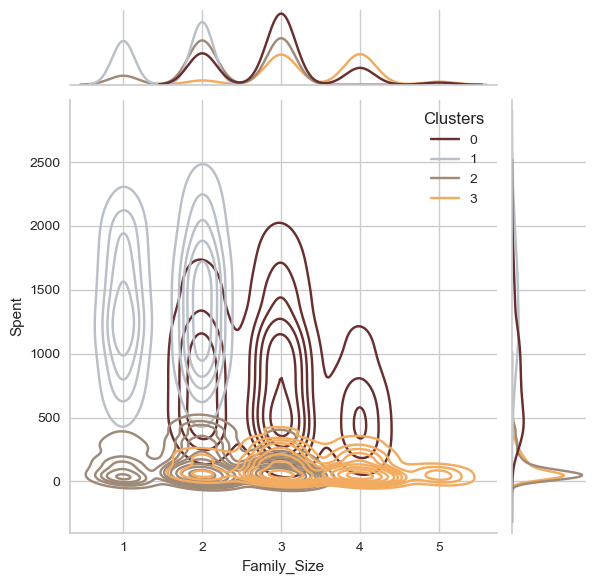

<Figure size 800x550 with 0 Axes>

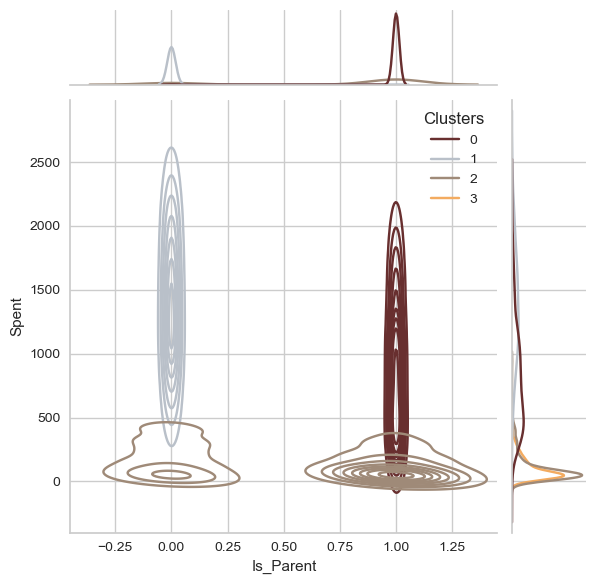

<Figure size 800x550 with 0 Axes>

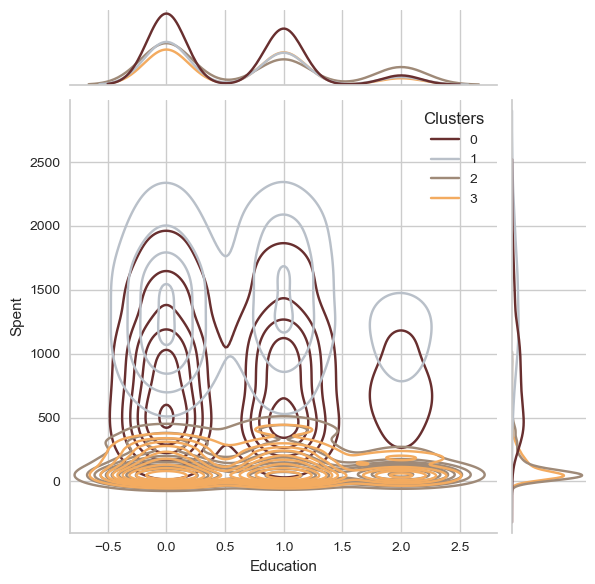

<Figure size 800x550 with 0 Axes>

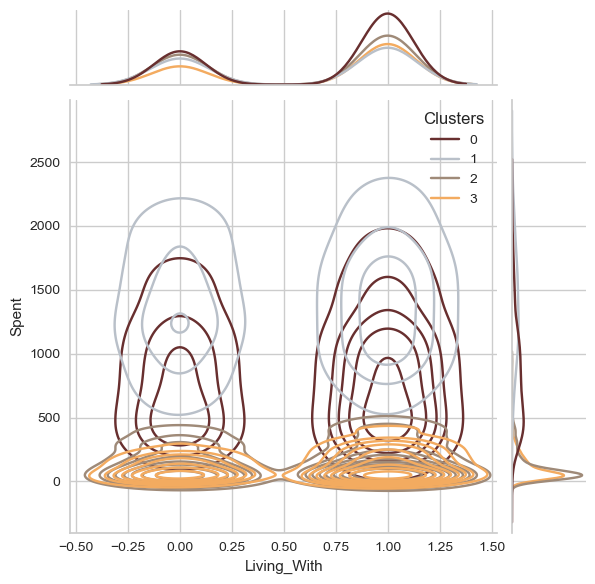

In [102]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()

-----------------

# Task 2. Regression

# Importing libraries

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading the data

In [45]:
cities = pd.read_csv('/Users/admin/Desktop/ML project/Code/Regression/cities.csv') 
movehubqualityoflife = pd.read_csv('/Users/admin/Desktop/ML project/Code/Regression/movehubqualityoflife.csv')
movehubcostofliving = pd.read_csv('/Users/admin/Desktop/ML project/Code/Regression/movehubcostofliving.csv')

# Data Preprocessing

In [46]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3543 entries, 0 to 3542
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   City     3543 non-null   object
 1   Country  3540 non-null   object
dtypes: object(2)
memory usage: 55.5+ KB


In [47]:
missing_values = cities.isnull().sum()
print(missing_values)

City       0
Country    3
dtype: int64


## Take care of missing values

In [48]:
cities.iloc[654,1]='Ukraine'
cities.iloc[724,1]='Russia'
cities.iloc[1529,1]='Kosovo'

In [49]:
#Make sure there's no missing values
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3543 entries, 0 to 3542
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   City     3543 non-null   object
 1   Country  3543 non-null   object
dtypes: object(2)
memory usage: 55.5+ KB


In [50]:
#Checking other 2 datasets
movehubqualityoflife.info()
movehubcostofliving.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   City             216 non-null    object 
 1   Movehub Rating   216 non-null    float64
 2   Purchase Power   216 non-null    float64
 3   Health Care      216 non-null    float64
 4   Pollution        216 non-null    float64
 5   Quality of Life  216 non-null    float64
 6   Crime Rating     216 non-null    float64
dtypes: float64(6), object(1)
memory usage: 11.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   216 non-null    object 
 1   Cappuccino             216 non-null    float64
 2   Cinema                 216 non-null    float64
 3   Wine                   216 non-null    float64
 4   Gasoline

## Mergining the dataset 


In [51]:
movehubcity = pd.merge(movehubqualityoflife, movehubcostofliving, how ='outer')

#Sorting data by 'City'
movehubcity = movehubcity.sort_values(by='City')

#Modification of the values of the index
movehubcity.reset_index(drop = True)

,City,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating,Cappuccino,Cinema,Wine,Gasoline,Avg Rent,Avg Disposable Income
0,Aachen,81.64,60.55,73.25,11.69,90.52,15.34,2.05,6.88,4.26,1.33,767.23,1619.72
1,Aberdeen,81.89,49.70,82.86,34.31,76.77,24.22,1.99,6.98,5.98,1.37,1195.74,1743.78
2,Abu Dhabi,86.40,68.03,48.02,53.42,80.80,10.86,2.67,6.23,13.73,0.30,1779.93,2135.92
3,Addis Ababa,59.88,6.38,63.89,85.59,28.41,26.04,0.46,2.29,4.18,0.72,653.77,124.22
4,Adelaide,87.29,72.03,56.25,12.01,91.54,41.32,2.49,11.42,10.08,0.95,1382.26,2911.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,Warsaw,76.76,35.77,63.33,86.16,51.82,32.03,1.66,5.19,5.19,1.18,726.59,664.31
212,Washington,81.74,56.61,64.44,30.55,76.92,51.43,2.37,7.85,7.85,0.69,2451.63,2484.32
213,Wellington,81.06,49.11,73.72,30.55,79.83,27.38,2.20,8.82,8.27,1.17,1515.65,1763.67
214,Zagreb,73.84,26.71,52.78,83.45,47.59,32.29,1.12,3.70,4.48,1.23,504.36,605.23


In [52]:
#Insert column country to dataset and create data.
data= pd.merge(movehubcity, cities, how = 'left',on='City')

#Rechecking NaN values after merge
data.info()
data[data['Country'].isnull()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 0 to 227
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   228 non-null    object 
 1   Movehub Rating         228 non-null    float64
 2   Purchase Power         228 non-null    float64
 3   Health Care            228 non-null    float64
 4   Pollution              228 non-null    float64
 5   Quality of Life        228 non-null    float64
 6   Crime Rating           228 non-null    float64
 7   Cappuccino             228 non-null    float64
 8   Cinema                 228 non-null    float64
 9   Wine                   228 non-null    float64
 10  Gasoline               228 non-null    float64
 11  Avg Rent               228 non-null    float64
 12  Avg Disposable Income  228 non-null    float64
 13  Country                198 non-null    object 
dtypes: float64(12), object(2)
memory usage: 26.7+ KB


,City,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating,Cappuccino,Cinema,Wine,Gasoline,Avg Rent,Avg Disposable Income,Country
10,Asheville,83.17,70.51,79.02,30.55,81.34,30.21,1.80,5.88,7.85,0.64,1225.82,1898.54,NaN
51,Cebu,66.93,12.90,73.70,35.90,41.21,46.88,1.43,2.85,3.48,0.88,475.01,200.28,NaN
61,Cordoba,73.76,27.56,75.24,48.76,47.68,51.56,1.95,3.92,4.25,0.93,524.80,523.02,NaN
66,Davao,69.29,17.63,69.00,77.98,30.66,17.71,0.79,1.90,3.17,0.84,554.18,158.34,NaN
74,Dusseldorf,83.45,72.52,75.98,8.61,88.02,15.34,2.13,8.31,4.47,1.28,1193.48,2301.70,NaN
79,Frankfurt,82.75,62.60,65.33,14.54,88.04,27.55,2.13,7.67,4.07,1.36,1022.98,1875.46,NaN
81,Galway,83.19,58.59,52.97,52.47,77.85,40.78,2.13,7.67,6.39,1.39,852.48,1875.46,NaN
100,Istanbul,80.22,34.42,80.38,44.98,45.67,42.36,1.99,5.44,9.06,1.66,634.23,724.84,NaN
101,Izmir,76.07,32.12,57.33,30.55,42.90,25.91,1.81,4.71,7.25,1.69,543.63,590.57,NaN
122,Lodz,73.32,26.37,53.21,37.21,46.29,64.51,1.45,4.77,4.15,1.18,337.35,415.20,NaN


In [53]:
#Taking care of missing values after merge
data.iloc[10,13]='United States' 
data.iloc[51,13]='Philippines'
data.iloc[61,13]='Argentina'
data.iloc[66,13]='Philippines' 
data.iloc[74,13]='Germany'
data.iloc[79,13]='Germany'
data.iloc[81,13]='Ireland'
data.iloc[100,13]='Turkey'
data.iloc[101,13]='Turkey'
data.iloc[122,13]='Poland'
data.iloc[129,13]='Spain'
data.iloc[130,13]='Scania'
data.iloc[134,13]='Spain'
data.iloc[136,13]='Colombia'
data.iloc[139,13]='United States'
data.iloc[141,13]='United States'
data.iloc[164,13]='Thailand'
data.iloc[166,13]='United States'
data.iloc[167,13]='United States'
data.iloc[168,13]='United States'
data.iloc[176,13]='Brazil'
data.iloc[178,13]='United States'
data.iloc[183,13]='United States'
data.iloc[184,13]='United States'
data.iloc[185,13]='United States'
data.iloc[188,13]='Brazil'
data.iloc[193,13]='Malta'
data.iloc[201,13]='United States'
data.iloc[224,13]='United states'
data.iloc[227,13]='Switzerland'

#Update wrong names of some of the cities
data.iloc[224,0]='Washington D.C'
data.iloc[66,0]='Davao City'

#Checking again for NAN's
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228 entries, 0 to 227
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   City                   228 non-null    object 
 1   Movehub Rating         228 non-null    float64
 2   Purchase Power         228 non-null    float64
 3   Health Care            228 non-null    float64
 4   Pollution              228 non-null    float64
 5   Quality of Life        228 non-null    float64
 6   Crime Rating           228 non-null    float64
 7   Cappuccino             228 non-null    float64
 8   Cinema                 228 non-null    float64
 9   Wine                   228 non-null    float64
 10  Gasoline               228 non-null    float64
 11  Avg Rent               228 non-null    float64
 12  Avg Disposable Income  228 non-null    float64
 13  Country                228 non-null    object 
dtypes: float64(12), object(2)
memory usage: 26.7+ KB


In [54]:
#Replace '' in column names by '_' and view the final dataset
data.columns = data.columns.str.replace(' ','_')

# Data Visualisation

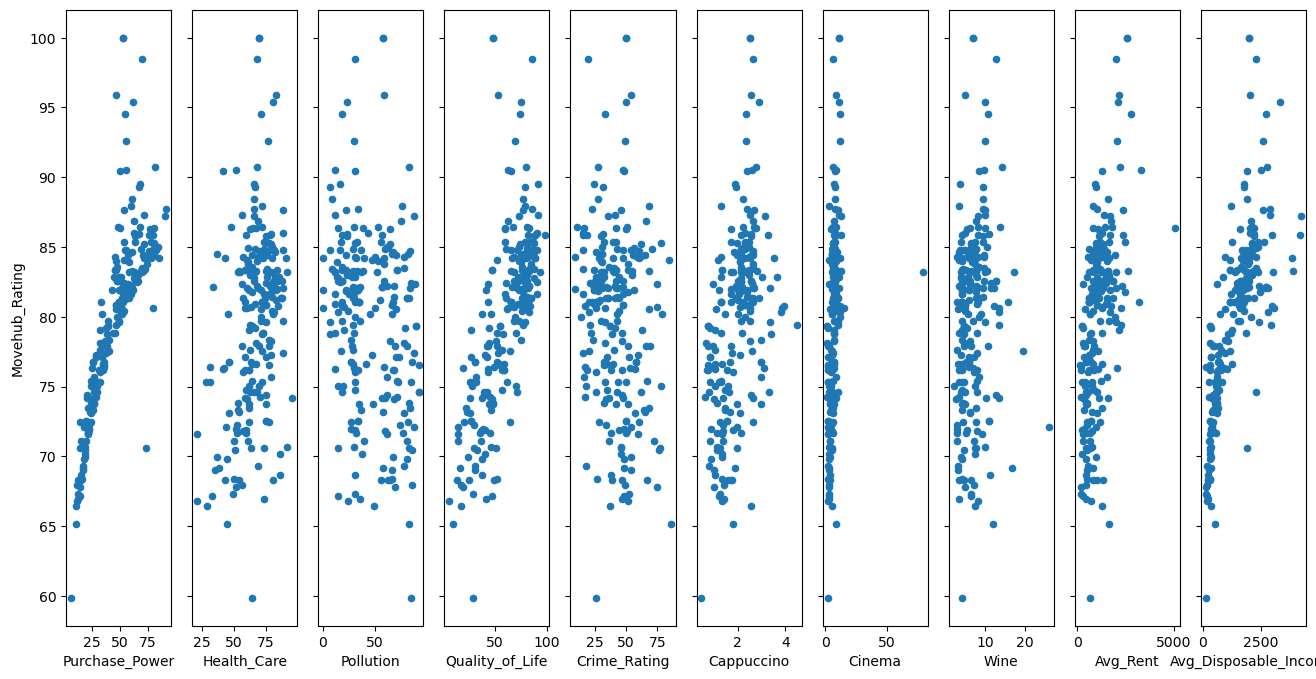

In [55]:
fig, axs = plt.subplots(1, 10, sharey=True)
data.plot(kind='scatter', x='Purchase_Power', y='Movehub_Rating', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='Health_Care', y='Movehub_Rating', ax=axs[1])
data.plot(kind='scatter', x='Pollution', y='Movehub_Rating', ax=axs[2])
data.plot(kind='scatter', x='Quality_of_Life', y='Movehub_Rating', ax=axs[3])
data.plot(kind='scatter', x='Crime_Rating', y='Movehub_Rating', ax=axs[4])
data.plot(kind='scatter', x='Cappuccino', y='Movehub_Rating', ax=axs[5])
data.plot(kind='scatter', x='Cinema', y='Movehub_Rating', ax=axs[6])
data.plot(kind='scatter', x='Wine', y='Movehub_Rating', ax=axs[7])
data.plot(kind='scatter', x='Avg_Rent', y='Movehub_Rating', ax=axs[8])
data.plot(kind='scatter', x='Avg_Disposable_Income', y='Movehub_Rating', ax=axs[9])
plt.show()

In [56]:
#Droping outliers
data = data.loc[(data['Movehub_Rating'] >= 65)]

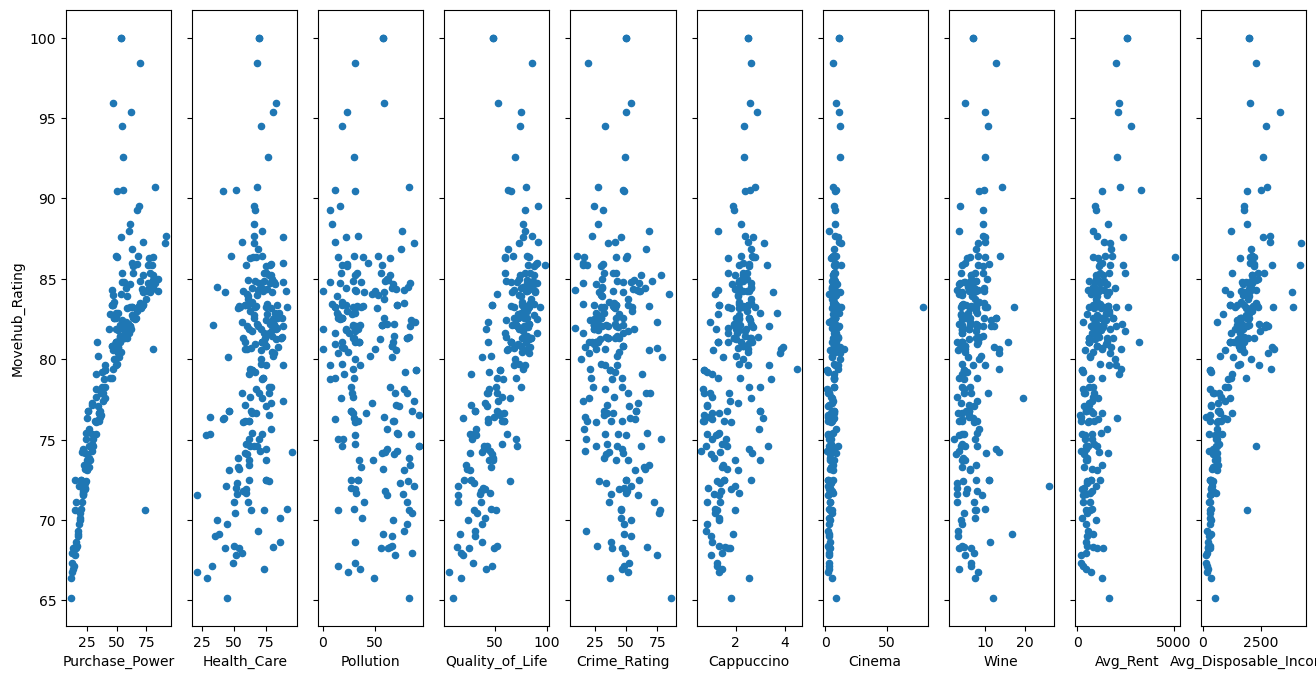

In [57]:
fig, axs = plt.subplots(1, 10, sharey=True)
data.plot(kind='scatter', x='Purchase_Power', y='Movehub_Rating', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='Health_Care', y='Movehub_Rating', ax=axs[1])
data.plot(kind='scatter', x='Pollution', y='Movehub_Rating', ax=axs[2])
data.plot(kind='scatter', x='Quality_of_Life', y='Movehub_Rating', ax=axs[3])
data.plot(kind='scatter', x='Crime_Rating', y='Movehub_Rating', ax=axs[4])
data.plot(kind='scatter', x='Cappuccino', y='Movehub_Rating', ax=axs[5],figsize=(16, 8))
data.plot(kind='scatter', x='Cinema', y='Movehub_Rating', ax=axs[6])
data.plot(kind='scatter', x='Wine', y='Movehub_Rating', ax=axs[7])
data.plot(kind='scatter', x='Avg_Rent', y='Movehub_Rating', ax=axs[8])
data.plot(kind='scatter', x='Avg_Disposable_Income', y='Movehub_Rating', ax=axs[9])
plt.show()

# Splitting data into Training and Test sets

In [58]:
from sklearn.model_selection import train_test_split
X = data.drop(['Movehub_Rating','Country','City'], axis = 1) 
y = data['Movehub_Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Creating a Liniar Regression

In [59]:
from sklearn import linear_model
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train,y_train)

LinearRegression()

### Making the prediction

In [66]:
y_pred_linear_reg = linear_reg.predict(X_test)

### Evaluation

In [70]:
from sklearn.metrics import mean_squared_error
mean_squared_error=mean_squared_error(y_test, y_pred_linear_reg)

#to print summary statistics
import statsmodels.formula.api as sm
import statsmodels.api as sm


#Adding intercept trems to X_train
X_train_mod = np.append(arr = np.ones((X_train.shape[0],1)).astype(int),values = X_train,axis = 1)
regressor_OLS = sm.OLS(endog=y_train, exog=X_train_mod).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Movehub_Rating   R-squared:                       0.789
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     57.34
Date:                Sat, 30 Mar 2024   Prob (F-statistic):           3.26e-51
Time:                        18:10:52   Log-Likelihood:                -441.65
No. Observations:                 181   AIC:                             907.3
Df Residuals:                     169   BIC:                             945.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         60.0819      2.407     24.962      0.000      55.330      64.833
x1             0.2562      0.028      9.059      0.000       0.200       0.312
x2             0.0038      0.019      0.202      0.840      -0.033       0.040
x3             0.0044      0.010      0.451      0.653      -0.015       0.024
x4             0.0341      0.025      1.343      0.181      -0.016       0.084
x5             0.0160      0.017      0.950      0.343      -0.017       0.049
x6            -0.9368      0.510     -1.838      0.068      -1.943       0.069
x7             0.2441      0.180      1.353      0.178      -0.112       0.600
x8             0.1248      0.096      1.300      0.195      -0.065       0.314
x9             2.9488      0.940      3.136      0.002       1.093       4.805
x10            0.0038      0.001      5.652      0.000       0.002       0.005
x11           -0.0022      0.001     -2.779      0.006      -0.004      -0.001
==============================================================================
Omnibus:                       39.232   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.731
Skew:                           0.634   Prob(JB):                     2.12e-45
Kurtosis:                       8.067   Cond. No.                     2.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
print("Mean Squared Error(MSE) of the test set: {:.3f} ".format(mean_squared_error))


Mean Squared Error(MSE) of the test set: 22.923 


### Drop variables and do train_test_split

In [72]:
X = data.drop(['Movehub_Rating','Country','City','Health_Care','Pollution','Quality_of_Life','Crime_Rating','Cinema','Wine'], axis = 1) 
y = data['Movehub_Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [73]:
linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train,y_train)

LinearRegression()


## Making the prediction

In [74]:
y_pred_linear_reg = linear_reg.predict(X_test)


In [76]:
from sklearn.metrics import mean_squared_error
mean_squared_error = mean_squared_error(y_test, y_pred_linear_reg)

#to print summary statistics
import statsmodels.formula.api as sm
import statsmodels.api as sm

#Adding intercept trems to X_train
X_train_mod = np.append(arr = np.ones((X_train.shape[0],1)).astype(int),values = X_train,axis = 1)
regressor_OLS = sm.OLS(endog=y_train, exog=X_train_mod).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Movehub_Rating   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     125.6
Date:                Sat, 30 Mar 2024   Prob (F-statistic):           5.60e-56
Time:                        18:18:19   Log-Likelihood:                -444.46
No. Observations:                 181   AIC:                             900.9
Df Residuals:                     175   BIC:                             920.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.2475      1.237     51.138      0.000      60.807      65.688
x1             0.2648      0.023     11.584      0.000       0.220       0.310
x2            -0.4442      0.433     -1.027      0.306      -1.298       0.409
x3             2.7958      0.681      4.104      0.000       1.451       4.140
x4             0.0040      0.001      6.425      0.000       0.003       0.005
x5            -0.0015      0.001     -2.080      0.039      -0.003   -7.69e-05
==============================================================================
Omnibus:                       38.808   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.454
Skew:                           0.640   Prob(JB):                     3.61e-43
Kurtosis:                       7.927   Cond. No.                     1.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [77]:
print("Mean Squared Error(MSE) of the test set: {:.3f} ".format(mean_squared_error))


Mean Squared Error(MSE) of the test set: 19.350 



# Creating a Support Vector Regression (SVR)

In [78]:
X = data.drop(['Movehub_Rating','Country','City'], axis = 1) 
y = data['Movehub_Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [79]:
from sklearn.svm import SVR
regressor = SVR(kernel ='linear')
regressor.fit(X_train, y_train)

SVR(kernel='linear')

## Making a prediction

In [80]:
y_pred_SVR = regressor.predict(X_test)


In [81]:
from sklearn.metrics import mean_squared_error
mean_squared_error = mean_squared_error(y_test, y_pred_SVR)

In [82]:
print("Mean Squared Error(MSE) of the test set: {:.3f} ".format(mean_squared_error))


Mean Squared Error(MSE) of the test set: 21.480 


------------


# Task 3. CLASSIFICATION


# Imorting Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb


## Loading the data

In [14]:
training_set = pd.read_csv('/Users/admin/Desktop/ML project/Code/Classification/datatraining.txt')
test_set = pd.read_csv('/Users/admin/Desktop/ML project/Code/Classification/datatest.txt')

In [15]:
training_set.head()


,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [16]:
training_set.describe()


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000,8143.000000
mean,20.619084,25.731507,119.519375,606.546243,0.003863,0.212330
std,1.016916,5.531211,194.755805,314.320877,0.000852,0.408982
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,19.700000,20.200000,0.000000,439.000000,0.003078,0.000000
50%,20.390000,26.222500,0.000000,453.500000,0.003801,0.000000
75%,21.390000,30.533333,256.375000,638.833333,0.004352,0.000000
max,23.180000,39.117500,1546.333333,2028.500000,0.006476,1.000000


In [17]:
training_set.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8143 entries, 1 to 8143
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 508.9+ KB


# Feature engineering

Text(0.5, 1.0, 'Distribution of Output variable (0/1)')

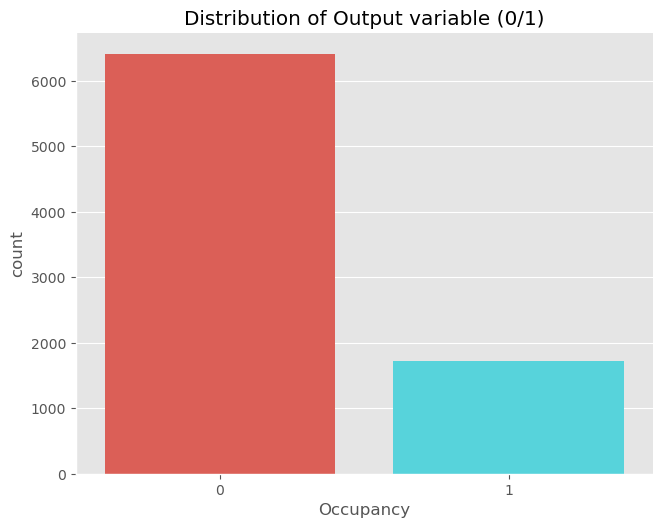

In [23]:
sb.set_palette("hls",2)
sb.FacetGrid(training_set, hue="Occupancy",height=5,aspect = 1.3)
sb.countplot(x="Occupancy", data=training_set, saturation=1).set_title("Distribution of Output variable (0/1)")



In [24]:
training_set['Occupancy'].value_counts()


0    6414
1    1729
Name: Occupancy, dtype: int64

/var/folders/fz/krj_p55n51n96d_v4wx0c7dr0000gn/T/ipykernel_21545/1444700746.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(training_set['Temperature'])


<Axes: xlabel='Temperature', ylabel='Density'>

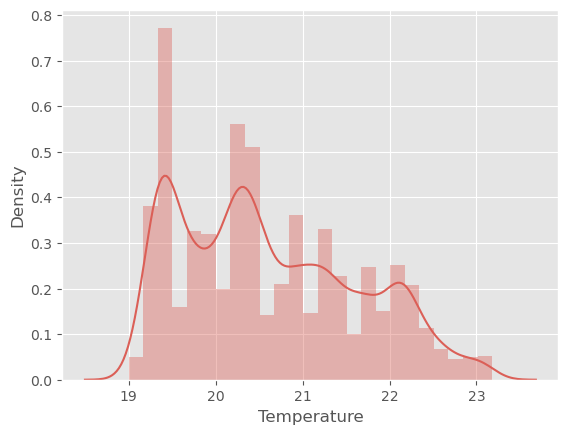

In [25]:
sb.distplot(training_set['Temperature'])


/var/folders/fz/krj_p55n51n96d_v4wx0c7dr0000gn/T/ipykernel_21545/658407870.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(training_set['Humidity'])


<Axes: xlabel='Humidity', ylabel='Density'>

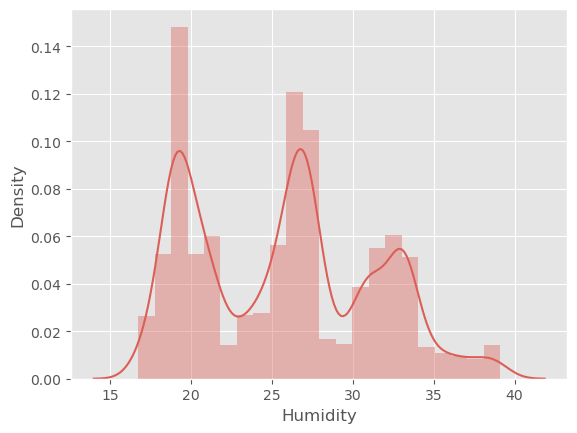

In [26]:
sb.distplot(training_set['Humidity'])


/var/folders/fz/krj_p55n51n96d_v4wx0c7dr0000gn/T/ipykernel_21545/1195982099.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(training_set['Light'])


(-250.0, 1000.0)

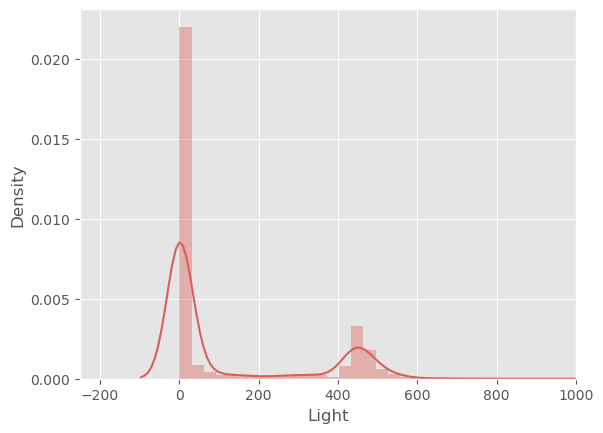

In [27]:
sb.distplot(training_set['Light'])
plt.xlim(-250, 1000)

/var/folders/fz/krj_p55n51n96d_v4wx0c7dr0000gn/T/ipykernel_21545/384448223.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(training_set['CO2'])


<Axes: xlabel='CO2', ylabel='Density'>

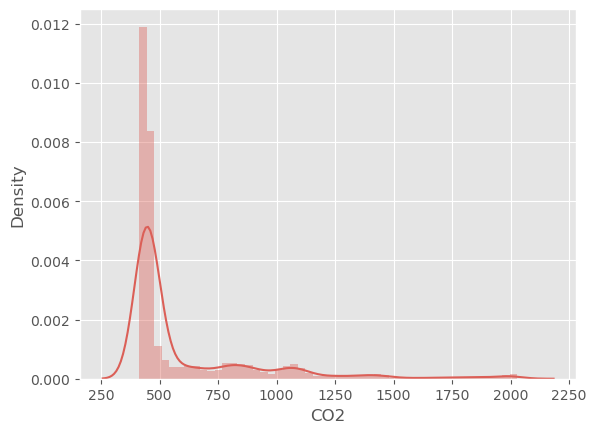

In [28]:
sb.distplot(training_set['CO2'])


/var/folders/fz/krj_p55n51n96d_v4wx0c7dr0000gn/T/ipykernel_21545/1265332265.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(training_set['HumidityRatio'])


<Axes: xlabel='HumidityRatio', ylabel='Density'>

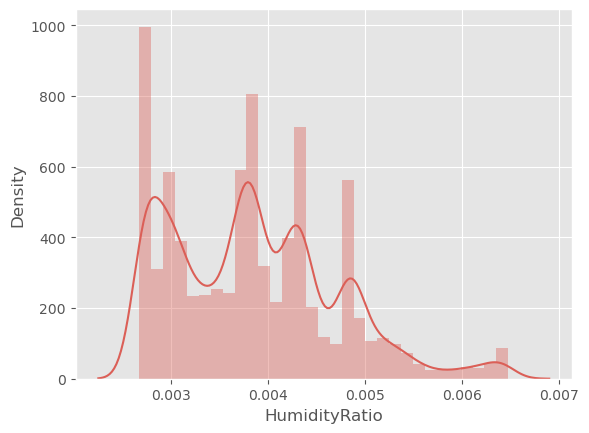

In [29]:
sb.distplot(training_set['HumidityRatio'])


# Visualisation of Feature Variables

/var/folders/fz/krj_p55n51n96d_v4wx0c7dr0000gn/T/ipykernel_21545/213486145.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = training_set.corr()


<Axes: >

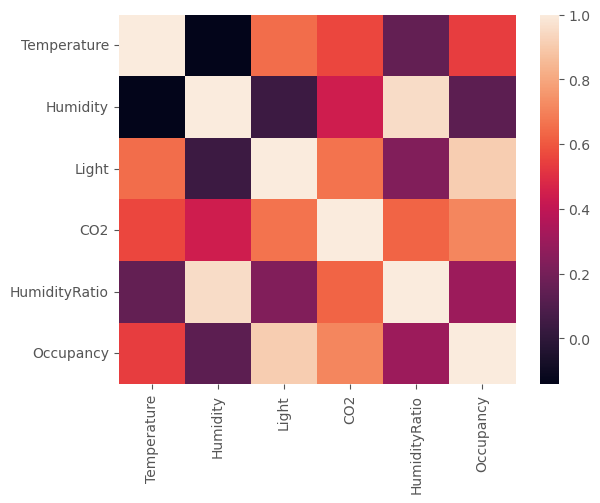

In [30]:
corr = training_set.corr()
sb.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

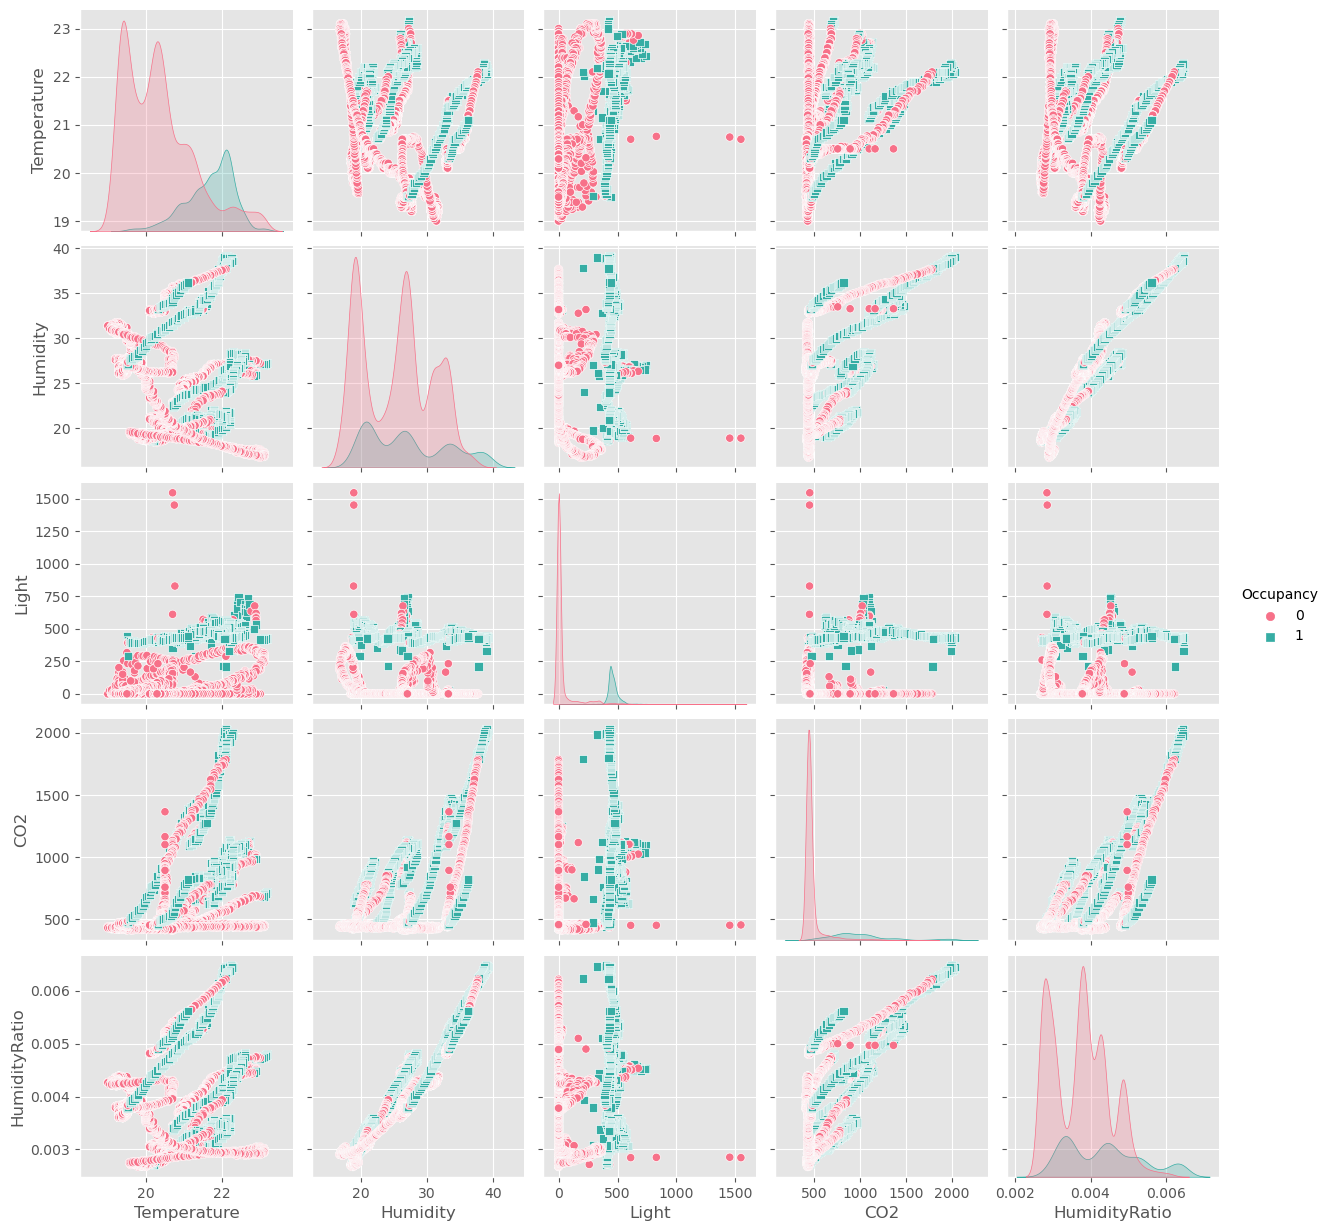

In [31]:
sb.pairplot(training_set, hue='Occupancy',palette="husl",markers=["o", "s"])


# Creating Training and Test set

In [33]:
#training set
X_train = training_set.iloc[:,1:6].values
y_train = training_set.iloc[:,6].values

#test set
X_test = test_set.iloc[:,1:6].values
y_test = test_set.iloc[:,6].values


# Feature Scaling

In [34]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Creating Classification model

## 1. Logistic Regression Classifier

In [35]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0,class_weight='balanced')
classifier.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=0)

In [37]:
# Making the prediction
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_logit = confusion_matrix(y_test, y_pred)
cm_logit

array([[1638,   55],
       [   2,  970]])

## 2. K-Nearest Neighbors Classifier


In [38]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2, weights='uniform')
classifier.fit(X_train, y_train)

# Making the prediction
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_knn = confusion_matrix(y_test, y_pred)
cm_knn

array([[1671,   22],
       [ 192,  780]])

## 3. Support Vector Machines (Linear kernel)


In [39]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0, class_weight='balanced')
classifier.fit(X_train, y_train)

# Making the prediction
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_svm = confusion_matrix(y_test, y_pred)
cm_svm

array([[1638,   55],
       [   2,  970]])

## 3.2 Support Vector Machines (Radial Kernel)


In [52]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0,class_weight='balanced')
classifier.fit(X_train, y_train)

#Making the prediction
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_KSVM = confusion_matrix(y_test, y_pred)
cm_KSVM

array([[1616,   77],
       [   3,  969]])

# 4. Naive Bayes Classifier


In [53]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Making the prediction
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_NB = confusion_matrix(y_test, y_pred)
cm_NB

array([[1638,   55],
       [   5,  967]])

## 5. Decision Tree Classifier


In [54]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0,class_weight='balanced')
classifier.fit(X_train, y_train)

# Making the prediction
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_dtree = confusion_matrix(y_test, y_pred)
cm_dtree

array([[1643,   50],
       [ 450,  522]])

## 6. Random Forest Classifier


In [55]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 300, criterion = 'entropy', random_state = 0,class_weight='balanced')
classifier.fit(X_train, y_train)

# Making the prediction
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_RF = confusion_matrix(y_test, y_pred)
cm_RF

array([[1642,   51],
       [  94,  878]])

### Module evaluations by creating Confusion Matrices

In [56]:
cmlist = [cm_logit,cm_knn,cm_svm,cm_KSVM,cm_NB,cm_dtree,cm_RF]


In [57]:
Accuracy = [];Precision = [];Recall =[];F1Score =[]


In [58]:
for i in range(7):
    temp = cmlist[i] 
    Accuracy.append((temp[0,0]+temp[1,1])/2665)
    Precision.append(temp[1,1]/(temp[1,1]+temp[0,1]))
    Recall.append(temp[1,1]/(temp[1,1]+temp[1,0]))
    F1Score.append(2*Precision[i]*Recall[i]/(Precision[i]+Recall[i]))

In [59]:
Algorithm = ['Logistic Regression','KNN ','SVM (Linear)','SVM(Kernel)','Naive Bayes','Decision Tree', 'Random Forests']


In [61]:
data = {
    'Algorithm': Algorithm,
    'Accuracy': Accuracy,
    'Precision': Precision,
    'Recall': Recall,
    'F1 Score': F1Score
}
df = pd.DataFrame(data)


df

,Algorithm,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.978612,0.946341,0.997942,0.971457
1,KNN,0.919700,0.972569,0.802469,0.879369
2,SVM (Linear),0.978612,0.946341,0.997942,0.971457
3,SVM(Kernel),0.969981,0.926386,0.996914,0.960357
4,Naive Bayes,0.977486,0.946184,0.994856,0.969910
5,Decision Tree,0.812383,0.912587,0.537037,0.676166
6,Random Forests,0.945591,0.945102,0.903292,0.923724
